In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from model import Model
from IPython import display
import cv2

%matplotlib inline
%reload_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 5)

def to_depth(disp, gt=False):
    width_to_focal = dict()
    width_to_focal[1242] = 721.5377
    width_to_focal[1241] = 718.856
    width_to_focal[1224] = 707.0493
    width_to_focal[1238] = 718.3351
    height, width = disp.shape
    if not gt:
        disp = width * cv2.resize(disp, (width, height), interpolation=cv2.INTER_LINEAR)
        depth = width_to_focal[width] * 0.54 / disp
        return depth
    else:
        mask = disp > 0
        depth = width_to_focal[width] * 0.54 / (disp + (1.0 - mask))
    return depth


In [12]:

model_GAN = Model(
    use_multiple_gpu=True,
    batch_size=16,
    val_dataset_dir='../depth/data_scene_flow/testing',
    train_dataset_dir='../depth/data_scene_flow/training',
    input_height=64,
    input_width=128,
    model_path='model' # GAN
)


model_CNN = Model(
    use_multiple_gpu=True,
    batch_size=16,
    val_dataset_dir='../depth/data_scene_flow/testing',
    train_dataset_dir='../depth/data_scene_flow/training',
    input_height=64,
    input_width=128,
    model_path='../torch_depth_cycleGAN/model' # GAN
)

model_GAN.load(True)
model_CNN.load(True)

out_GAN = model_GAN.test()
out_CNN = model_CNN.test()

Use a dataset with 400 images (mode=train)
Use a dataset with 400 images (mode=train)
Use a dataset with 400 images (mode=train)
Use a dataset with 400 images (mode=train)
load best True
load best True
RMSE tensor(6.6803, device='cuda:0')
      Test G: 0.972(0.972) D: 0.000 Time: 5.04s [S]
RMSE tensor(6.6639, device='cuda:0')
      Test G: 0.988(0.988) D: 0.000 Time: 4.50s [S]


In [44]:
def gt(path):
    import glob
    from PIL import Image
    files = glob.glob(path + '/*')
    N = len(files)
    D = np.zeros((N, 352, 1216))
    for i, fp in enumerate(files):
        im = Image.open(fp)
        data = np.array(im)
        D[i] = data
    return D

depths = gt('val/groundtruth_depth/image_2')

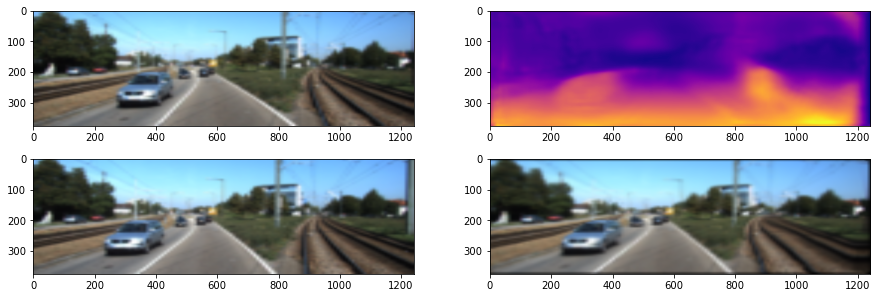

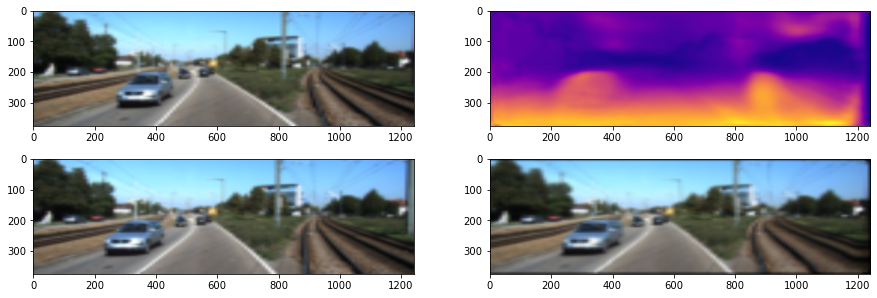

In [5]:

fig, ax = plt.subplots(ncols=2, nrows=2)

idx = 35

GAN_dispr, GAN_left, GAN_right, GAN_nright = out_GAN
CNN_dispr, CNN_left, CNN_right, CNN_nright = out_CNN

resized_i0 = cv2.resize(np.moveaxis(GAN_left[idx], 0, -1), (1242, 375), interpolation=cv2.INTER_LINEAR)
resized_dr = cv2.resize(np.abs(GAN_dispr[idx]), (1242, 375), interpolation=cv2.INTER_LINEAR)
resized_i1 = cv2.resize(np.moveaxis(GAN_right[idx], 0, -1), (1242, 375), interpolation=cv2.INTER_LINEAR)
resized_ir = cv2.resize(np.moveaxis(GAN_nright[idx], 0, -1), (1242, 375), interpolation=cv2.INTER_LINEAR)
ax[0][0].imshow(resized_i0)
ax[0][1].imshow(resized_dr, cmap='plasma') 
ax[1][0].imshow(resized_i1)
ax[1][1].imshow(resized_ir)


fig, ax = plt.subplots(ncols=2, nrows=2)

resized_i0 = cv2.resize(np.moveaxis(CNN_left[idx], 0, -1), (1242, 375), interpolation=cv2.INTER_LINEAR)
resized_dr = cv2.resize(np.abs(CNN_dispr[idx]), (1242, 375), interpolation=cv2.INTER_LINEAR)
resized_i1 = cv2.resize(np.moveaxis(CNN_right[idx], 0, -1), (1242, 375), interpolation=cv2.INTER_LINEAR)
resized_ir = cv2.resize(np.moveaxis(CNN_nright[idx], 0, -1), (1242, 375), interpolation=cv2.INTER_LINEAR)
ax[0][0].imshow(resized_i0)
ax[0][1].imshow(resized_dr, cmap='plasma') 
ax[1][0].imshow(resized_i1)
ax[1][1].imshow(resized_ir)

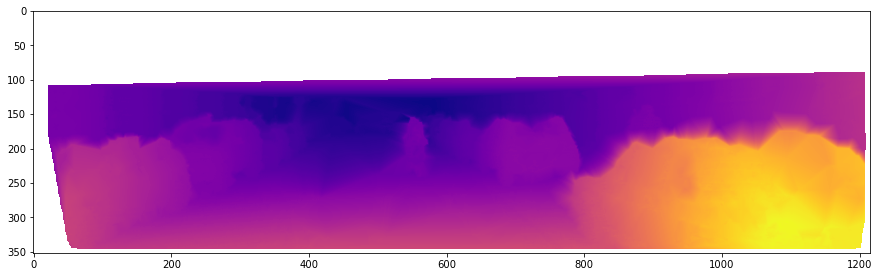

In [151]:


def fill(depth):
    from scipy import interpolate
    width, height = depth.shape
    x, y = np.arange(0, height), np.arange(0, width)
    arr = np.ma.masked_equal(depth, 0.0)
    xx, yy = np.meshgrid(x, y)
    x1 = xx[~arr.mask]
    y1 = yy[~arr.mask]
    newarr = arr[~arr.mask]
    inter = interpolate.griddata((x1, y1), newarr.ravel(), (xx, yy), method='linear')
    return 383.4 / inter
plt.imshow(fill(depths[35]), cmap='plasma')

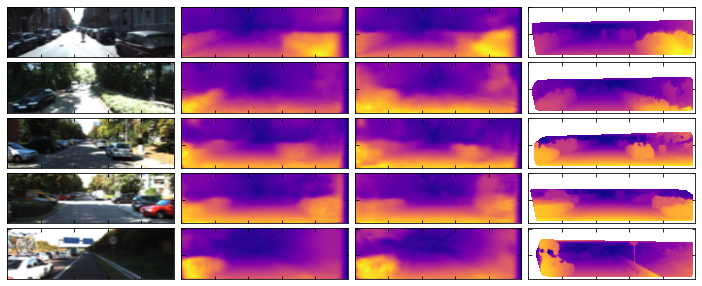

In [241]:

GAN_dispr, GAN_left, GAN_right, GAN_nright = out_GAN
CNN_dispr, CNN_left, CNN_right, CNN_nright = out_CNN


fig, ax = plt.subplots(ncols=4, nrows=5)
for i, idx in enumerate([35, 60, 100, 120, 440]):

    resized_d_GAN = cv2.resize(np.abs(GAN_dispr[idx]), (1242, 375), interpolation=cv2.INTER_LINEAR)
    resized_d_CNN = cv2.resize(np.abs(CNN_dispr[idx]), (1242, 375), interpolation=cv2.INTER_LINEAR)
    resized_left = cv2.resize(np.moveaxis(CNN_left[idx], 0, -1), (1242, 375), interpolation=cv2.INTER_LINEAR)
    resized_gt = cv2.resize(fill(depths[idx]), (1242, 375), interpolation=cv2.INTER_LINEAR)

    # if i < 5:
    ax[i][0].set_xticklabels([])
    ax[i][1].set_xticklabels([])
    ax[i][2].set_xticklabels([])
    ax[i][3].set_xticklabels([])
    ax[i][0].set_yticklabels([])
    ax[i][1].set_yticklabels([])
    ax[i][2].set_yticklabels([])
    ax[i][3].set_yticklabels([])

    ax[i][0].tick_params(direction='in', top=True, right=True)
    ax[i][1].tick_params(direction='in', top=True, right=True)
    ax[i][2].tick_params(direction='in', top=True, right=True)
    ax[i][3].tick_params(direction='in', top=True, right=True)
    ax[i][0].tick_params(direction='in', top=True, right=True)
    ax[i][1].tick_params(direction='in', top=True, right=True)
    ax[i][2].tick_params(direction='in', top=True, right=True)
    ax[i][3].tick_params(direction='in', top=True, right=True)

    ax[i][0].imshow(resized_left)
    ax[i][1].imshow(resized_d_GAN, cmap='plasma')
    ax[i][2].imshow(resized_d_CNN, cmap='plasma')
    ax[i][3].imshow(resized_gt, cmap='plasma')


fig.savefig('scene.png')

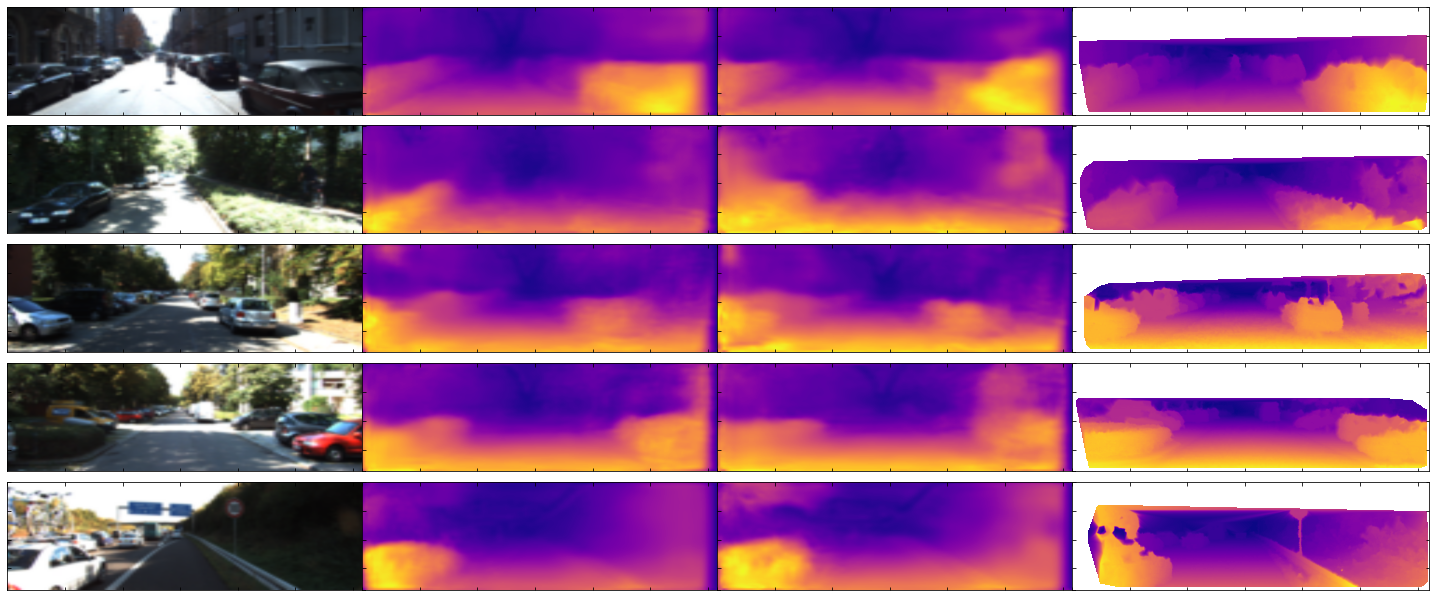

<Figure size 1080x360 with 0 Axes>

In [260]:
plt.subplots_adjust(wspace=0, hspace=0)
fig.set_size_inches(23, 8)
fig.tight_layout(True)
fig.savefig('scene.png', bbox_inches='tight')
fig